# Rotated pole coordinate transform


Three parameters define a general latitude/longitude coordinate system, formed
by a general rotation of the sphere. One choice for these parameters is the one considered in CF:

```
grid_mapping_name = rotated_latitude_longitude

Map parameters:

        grid_north_pole_latitude

        grid_north_pole_longitude

        north_pole_grid_longitude - This parameter is optional (default is 0).

Map coordinates:

    The rotated latitude and longitude coordinates are identified by the
    standard_name attribute values grid_latitude and grid_longitude
    respectively.
```


Grid Mapping Attributes

| Attribute | Description |
|---|---
| grid_mapping_name         | The name used to identify the grid mapping.                          |
| grid_north_pole_latitude  | True latitude (degrees_north) of the north pole of the rotated grid. |
| grid_north_pole_longitude | True longitude (degrees_east) of the north pole of the rotated grid. |
| north_pole_grid_longitude | Longitude (degrees) of the true north pole in the rotated grid.      |

As described, there is an ambiguity, since there are two ways to reach the same north pole position.
For instance, (long 190, lat 30) can be reached both by: 

  1. rotating 10 degrees around the Z axis and then doing a rotation of -60 degrees around the new Y axis;
  2. rotating 190 degrees around the Z axis and the doing a rotation of +60 degrees around the new Y axis.
  
Again, (long -169.5, lat 46.5): (yes, it would be the same of declaring a long of +190.5

  1. rotating +10.5 degrees around the Z axis and then doing a rotation of -33.5 degrees around the new Y axis
  2. rotating -169.5 degrees around the Z axis and then doing a rotation of +33.5 degrees around the new Y axis.

Again, (long 45.3, lat -34): 
  
  1. rotating 45.3 degrees around the Z axis and then doing a rotation of + (90 + 34) degrees around the new Y axis
  2. rotating (45.3 + 180) degrees around the Z axis and then doing a rotation of + (180 - 34) around the new Y axis

A way to fix this is to constrain the first rotation between -90, +90. Then only the first option will be avaliable.
  
The following is an implementation of this coordinate transform.

In [1]:
from math import pi
import numpy as np
import xarray as xr

def lonlat(true_long, true_lat, lonp, latp):
    """Map latp and lonp in the rotated pole coordinates to standard lat and lon
       true_lat is the true latitude of the north pole of the new coord system
       true_long   is the true longitude of the north pole of the new coord system
    """
    # we assume that the transform was first a rotation on the Z and then a rotation on the long=0 circle 
    true_long = true_long % 360
    if abs(true_long) > 90:
        phi = true_long - 180
        theta = -(90 - true_lat)
    else:
        phi = true_long
        theta = 90 - true_lat
    # phi is how much we, first, rotated around the Z axis
    # theta is how much we then rotated around the new Y axis
    theta = pi * (theta/180)
    phi = pi * (phi/180)
    latp = pi * latp/180
    lonp = pi * lonp/180
    lat = np.arcsin(np.cos(theta) * np.sin(latp) - np.cos(lonp) * np.sin(theta) * np.cos(latp))
    lon = np.arctan2(np.sin(lonp), np.tan(latp) * np.sin(theta) + np.cos(lonp) * np.cos(theta)) - phi
    return 180 * lon / pi, 180 * lat/pi

## Example: tdm moloch simulations

So, for instance, if we look at the coordinate system used in the moloch (add link) simulations,

```python
>>> d = xr.open_dataset(cf_fname)
>>> rpole = d.variables['rotated_pole']
>>> rpole.attrs
OrderedDict([('grid_mapping_name', 'rotated_latitude_longitude'),
             ('grid_north_pole_longitude', -169.5),
             ('grid_north_pole_latitude', 46.499996)])
```

In [2]:
d = xr.open_dataset("../moloch/data/moloch_20180501.nc")
rpole = d.variables['rotated_pole']
np_lon = rpole.attrs['grid_north_pole_longitude']
np_lat = rpole.attrs['grid_north_pole_latitude']
print(np_lon, np_lat)
rlat = d.variables['rlat'].values
rlon = d.variables['rlon'].values - 360 # just for aesthetic reasons

-169.5 46.499996


In [3]:
rlon.min(), rlon.max(), rlat.min(), rlat.max()

(-5.1000000000000227,
 7.9175999999999931,
 -8.0885999999999996,
 5.0442000000000009)

In [4]:
lonlat(-169.5, 46.5, 0, 0) # grid is centered here

(-10.5, 43.5)

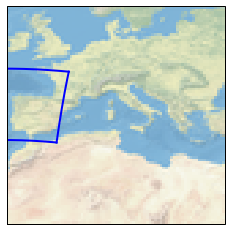

In [5]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent((-10, 30, 20, 60), crs=ccrs.PlateCarree())

left = lonlat(np_lon, np_lat, rlon.min(), rlat)
right = lonlat(np_lon, np_lat, rlon.max(), rlat)
bottom = lonlat(np_lon, np_lat, rlon, rlat.min())
top = lonlat(np_lon, np_lat, rlon, rlat.max())
for side in [bottom, left, top, right]:
    plt.plot(side[0], side[1],
             color='blue', linewidth=2, ## marker='o',
             transform=ccrs.PlateCarree(),
             )
plt.show()

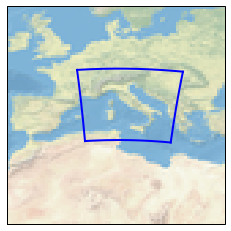

In [6]:
np_lon = - np_lon
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent((-10, 30, 20, 60), crs=ccrs.PlateCarree())

left = lonlat(np_lon, np_lat, rlon.min(), rlat)
right = lonlat(np_lon, np_lat, rlon.max(), rlat)
bottom = lonlat(np_lon, np_lat, rlon, rlat.min())
top = lonlat(np_lon, np_lat, rlon, rlat.max())
for side in [bottom, left, top, right]:
    plt.plot(side[0], side[1],
             color='blue', linewidth=2, ## marker='o',
             transform=ccrs.PlateCarree(),
             )
plt.show()